In [ ]:
Urban Data Science & Smart Cities <br>
URSP688Y Spring 2025<br>
Instructor: Chester Harvey <br>
Urban Studies & Planning <br>
National Center for Smart Growth <br>
University of Maryland

# Exercise03
## Huan: Research Title
Does the frequency of eviction events correlate with the type of nearby schools?
## Huan: Abstract
The study investigates if the frequency of eviction events correlate with the type of nearby schools. The study uses PreK thru 12 Education Public Schools location data and eviction records in Maryland, to explore if different types of schools (e.g., elementary, middle, and high schools) in Maryland have different number of eviction events. First, the study created 3km buffer zones around each school to count eviction events. Second, the eviction frequency within these zones was calculated and compared across school types. The result shows that eviction events are more frequent around mixed-level types of schools (e.g., PreK-8 schools, Middle/High schools, Elementary/Middle/High schools, Elementary/Middle schools), indicating a correlation between school type and housing instability. It is possible that schools serving multiple levels (e.g., Elementary/Middle/High) may be more prevalent in consolidated districts or underserved areas, which tend to have higher eviction rates due to economic stress. The findings suggest that mixed-level types of schools are surrounded by higher eviction frequencies, highlighting the need for targeted housing policies in these areas. 
## Huan: Pseudocode
1) Load 'Maryland_Education_Facilities__PreK_thru_12_Education_(Public_Schools).geojson' data and 'md_eviction_warrants_through_2024.geoparquet' data
2) Convert two types of data to the same projection: UTM Zone 18N (Maryland): EPSG:32618
3) Make a 3km-buffer zones around each school
4) Conduct spatial join and count average eviction number by school group
5) Rank average eviction counts by school type

## Problem

In the last exercise, you used tabular analyses to examine how eviction impacts tenants in Montgomery and Prince George's Counties. In this exercise, you will use more precise, address-level data to analyze evictions across the entire state through a spatial lens.

**You get to write your own research question, but with a few parameters:**
- It should be addressable with the provided eviction data
- It should require that you relate the eviction data to at least one other dataset, which you provide
- It should involve at least one form of spatial analysis (e.g., proximity, overlay, or measurement of another spatial relationship)

**Please write a short abstract (200-300 words) at the top of your exercise notebook that concisely summarizes your research question, how you addressed it, and the results of your analysis. Then provide reproducible code in cells below.**

### Bonus

Only a portion of the eviction records I'm providing for this exercise have addresses that can be geocoded (converting address strings to geographic coordinates) with a high degree of accuracy, or even at all. How could you assess bias in which records are accurately geocoded? (Hint: This will require you to define accuracy.) Can you write a Python script that evaluates whether higher- and lower-accuracy geocodes are randomly distributed across eviction records, or whether certain types of evictions are more or less likely to be geocoded well? **Please report your approach and findings in a separate paragraph and provide supporting code.**

## Data

[Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing)

I'm providing you with eviction warrant data for the whole state of Maryland from 2022 through December 2024. These are from the same District Court of Maryland and Department of Housing and Community Development (DHCD) [source](https://app.powerbigov.us/view?r=eyJrIjoiYWI1Yzg0YjYtNDFkZS00MDUyLThlMDctYmE1ZjY5MGI0MWJhIiwidCI6IjdkM2I4ZDAwLWY5YmUtNDZlNy05NDYwLTRlZjJkOGY3MzE0OSJ9&pageName=ReportSection) as the data from Exercise 2, but also include street addresses. While these data are technically public, it is best practice not to store address-level data on a public GitHub repository. It is also a best practice not to commit large raw data files to Git. For both these reasons, I have shared this dataset in a [Google Drive](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing) folder to which your UMD account has been invited. You should download `md_eviction_warrants_through_2024.csv` store it in the exercise03 directory on your computer before starting to code. 

There is a `.gitignore` file in the exercise03 directory that prevents any `.csv` file from being tracked by Git. As long as you don't modify this `.gitignore`, the raw data file won't get committed, pushed to your remote fork, or included in a pull request back to the course repo.

## File Management and Submitting
To submit, please:
1. Make a new branch on your fork for this exercise.
2. Make a notebook for your exercise with your first name as an underscored suffix (e.g., `exercise02_chester.ipynb`)
    - You can either copy this notebook to work off of or start with a fresh notebook. Your choice.
4. Make commits to that branch as you work on the exercise.
5. Don't commit the eviction warrant CSV or other raw data files to Git.
    - Instead, please add any other raw data files your analysis depends on the [Exercise 3 Google Drive Folder](https://drive.google.com/drive/folders/1-f7CIS-Nw9HWK1f3GUqhTLwhgtzDXVfl?usp=sharing).
    - The current `.gitignore` will prevent CSV files from committing. Add additional file names/extensions as necessary.
6. Make a pull request from your branch. Ensure that the only files included in your pull request are those you intended for this exercise.

## Getting Started
To get started, here's some code I developed for geocoding the address in each eviction warrant into a geographic coordinate. You can include all or parts of this code in your own exercise, or just run this notebook to produce the `md_eviction_warrants_through_2024.geoparquet` file and import it into your own notebook to use the results.

### U.S. Census Geocoder
This geocoding process makes use of a [free geocoder provided by the US Census](https://geocoding.geo.census.gov/geocoder/). It's not the most accurate geocoder available, but it's free and fast.

### Breaking Code Into Modules
In this geocoding process, I'm demonstrating an approach to coding where you break code up into multiple modules and then import names between modules. This helps keep things tidy, allows you to easily reuse code that's generalizable between applications (e.g., the `utils.py` module here), and organize code used for more specific purposes (e.g., the `exercise03.py` and `census_geocode.py` modules).

This is exactly how packages work——modules are the basic building blocks. If you wrote an interconnected set of modules to address a certain problem space, you could publish it as a package and let others download it with conda or pip. That's how open-source software gets its start!

In [1]:
import pandas as pd
import geopandas as gpd
import utils
import exercise03
import census_geocode

%load_ext autoreload
%autoreload 2

In [2]:
# Load warrants and make sure zip codes are stored as strings without decimals
warrants_df = pd.read_csv('md_eviction_warrants_through_2024.csv')
warrants_df['TenantZipCode'] = warrants_df['TenantZipCode'].astype('Int64').astype('string')
len(warrants_df) # How many warrants are we working with?

411040

In [3]:
# Rather than geocoding 400K+ addresses, could we get only the unique ones?
geocode_input_df = exercise03.prep_warrants_for_geocoding(warrants_df)

411040 warrants input
Reduced to 167949 unique addresses


In [4]:
# The Census Geocoder API can only accept up to 10K rows at a time, so we have to break
# our dataframe into chunks

# Split into dataframes with less than 10K rows each
geocode_input_dfs = utils.chunk_dataframe(geocode_input_df, 9999)

# Save each dataframe as a CSV without a header
utils.save_dfs_to_csv(geocode_input_dfs, 'geocode_inputs', header=False)

split dataframe into 17 chunks


In [5]:
# Geocode addresses with the Census Geocoder (set test=True to process only one file)
census_geocode.geocode_csvs('geocode_inputs', 'geocode_outputs')

Processing file: geocode_inputs/df_14.csv


KeyboardInterrupt: 

In [6]:
# Recombine outputs from geocoder into a single dataframe
geocode_output_df = exercise03.combine_census_geocoded_csvs('geocode_outputs')
len(geocode_output_df)

167949

In [7]:
# Merge geocoded address back onto the inputs with separate fields for address, city, state, and zip
geocoded_df = geocode_input_df.merge(geocode_output_df, left_index=True, right_index=True)
len(geocoded_df)

167949

In [8]:
# Use address, city, state, and zip columns to join geocodes onto original warrant records
warrants_df = warrants_df.merge(geocoded_df, on=['TenantAddress','TenantCity','TenantState','TenantZipCode'])
len(warrants_df)

411040

In [9]:
# Convert warrants into a geodataframe with points
warrants_gdf = utils.lonlat_str_to_geodataframe(warrants_df, 'match_lon_lat')

In [10]:
# What proportion of records have points?
len(warrants_gdf[warrants_gdf.lon.notnull()]) / len(warrants_gdf)

0.9458057609964967

In [11]:
# What proportion of records have exact geocode matches?
len(warrants_gdf[warrants_gdf.match_type == 'Exact']) / len(warrants_gdf)

0.5598554885169327

Parquet is a file format for tabular data that efficiently stores data of many types, including a 'geoparquet' variant that stores geometries like points, lines, and polygons. You can easily save a dataframe or geodataframe to parquet with the `.to_parquet` method. The resulting file will be much smaller and load faster than more convetional formats, such as CSV or shapefile. The downside is that you won't be able to open it with Excel, ArcGIS, or other conventional desktop software.

In [13]:
warrants_gdf.to_parquet('md_eviction_warrants_through_2024.geoparquet')

You can load a parquet file back to a dataframe with `pd.read_parquet('filename')` or a geoparquet back to a geodataframe with `gpd.read_parquet('filename')`

In [14]:
gdf = gpd.read_parquet('md_eviction_warrants_through_2024.geoparquet')

In [15]:
gdf.columns.tolist()

['ID',
 'EventDate',
 'EventType',
 'EventComment',
 'County',
 'Location',
 'TenantAddress',
 'TenantCity',
 'TenantState',
 'TenantZipCode',
 'CaseType',
 'CaseNumber',
 'EvictedDate',
 'Source',
 'SourceDate',
 'Year',
 'EvictionYear',
 'unique_id',
 'input_address',
 'match_status',
 'match_type',
 'match_address',
 'match_lon_lat',
 'match_tiger_line_id',
 'match_tiger_line_side',
 'lon',
 'lat',
 'geometry']

In [16]:
gdf.head()

,ID,EventDate,EventType,EventComment,County,Location,TenantAddress,TenantCity,TenantState,TenantZipCode,...,input_address,match_status,match_type,match_address,match_lon_lat,match_tiger_line_id,match_tiger_line_side,lon,lat,geometry
0,1.0,1/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,10 Light St Apt 1422,Baltimore,MD,21202,...,"8115 Crispin Court, Glen Burnie, MD, 21061",Match,Exact,"8115 CRISPIN CT, GLEN BURNIE, MD, 21061","-76.635049620852,39.129829502298",68194356.0,R,-76.635049620852,39.129829502298,POINT (-76.63505 39.12983)
1,2.0,1/23/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,5543 Force Rd,Baltimore,MD,21206,...,"8464 Fieldstone Way, Landover, MD, 20785",Match,Exact,"8464 FIELDSTONE WAY, LANDOVER, MD, 20785","-76.862795121452,38.893420645382",640260555.0,L,-76.862795121452,38.893420645382,POINT (-76.8628 38.89342)
2,3.0,8/17/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2418 Marbourne Ave #3B,Baltimore,MD,21230,...,"8113 Crispin Court, Glen Burnie, MD, 21061",Match,Exact,"8113 CRISPIN CT, GLEN BURNIE, MD, 21061","-76.635059028234,39.129819049651",68194356.0,R,-76.635059028234,39.129819049651,POINT (-76.63506 39.12982)
3,4.0,8/19/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,2502 W Patapsco #3D,Baltimore,MD,21230,...,"821 Caslon Way #210, Landover, MD, 20785",No_Match,None,None,None,NaN,None,None,None,POINT EMPTY
4,5.0,9/9/2022,Warrant of Restitution - Return of Service - E...,None,Baltimore City,Baltimore City,611 S Charles St #361,Baltimore,MD,21230,...,"8065 Crainmont Drive East, Glen Burnie, MD, 21061",Match,Non_Exact,"8065 E CRAINMONT DR, GLEN BURNIE, MD, 21061","-76.63478020404,39.131556986157",68179530.0,R,-76.63478020404,39.131556986157,POINT (-76.63478 39.13156)


In [88]:
#Start here!
#Does the frequency of eviction events correlate with the type of nearby schools?

#load eviction data and count unique cases
uni_warrants_gdf = gdf.drop_duplicates(subset='CaseNumber')

#load school data

schools = gpd.read_file("Maryland_Education_Facilities_-_PreK_thru_12_Education_(Public_Schools).geojson")

print(schools.head())
print(uni_warrants_gdf.head())
print(schools.crs)

# make the same projection: UTM Zone 18N (Maryland): EPSG:32618.
evictions_utm = uni_warrants_gdf.to_crs(epsg=32618)
schools_utm = schools.to_crs(epsg=32618)

EPSG:4326


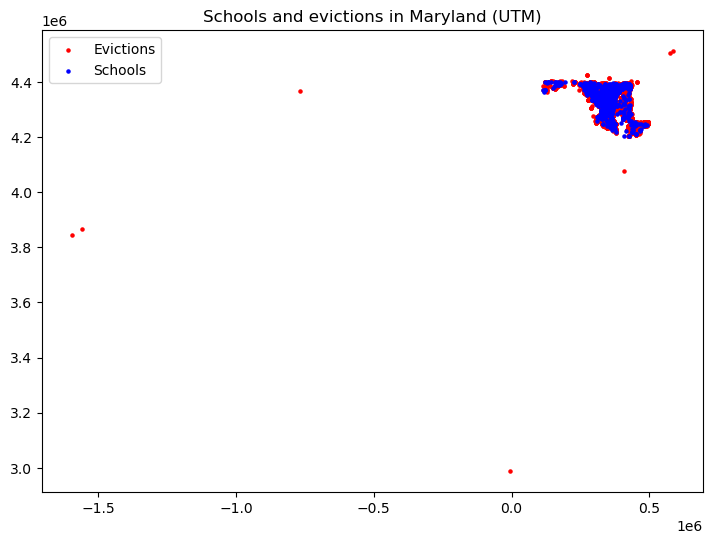

In [89]:
# draw a map to check if in the same projection
fig, ax = plt.subplots(figsize=(10, 6))
evictions_utm.plot(ax=ax, color='red', markersize=5, label='Evictions')
schools_utm.plot(ax=ax, color='blue', markersize=5, label='Schools')
plt.legend()
plt.title('Schools and evictions in Maryland (UTM)')
plt.show()

In [86]:
# Create buffers around each school (3 km)
schools_utm['buffer'] = schools_utm.geometry.buffer(3000)

# Perform spatial join to find eviction events within school buffer zones
eviction_counts = gpd.sjoin(evictions_utm, schools_utm.set_geometry('buffer'), predicate='within').groupby('OBJECTID').size()

# Map the eviction counts back to the schools 'OBJECTID'
schools_utm['eviction_count'] = schools_utm['OBJECTID'].map(eviction_counts).fillna(0)
# Group schools by type and calculate average eviction count
grouped = schools_utm.groupby('School_Type')['eviction_count'].mean()

# Priny average eviction counts by school type
print("Average eviction counts by school type:")
print(grouped)

Average eviction counts by school type:
School_Type
Administrative               0.000000
Alternate                 1058.400000
Career Tech               1708.300000
Elementary                1985.967213
Elementary/Middle         4762.222222
Elementary/Middle/High    4982.500000
Environmental Ed.           12.000000
High                      2240.951087
Middle                    1372.560386
Middle/High               6680.900000
PreK-8                    8521.250000
Science                   1287.500000
Special Ed.               1938.814815
Name: eviction_count, dtype: float64


In [90]:
grouped_sorted = grouped.sort_values(ascending=False)
print("Average eviction counts by school type (ranked):")
print(grouped_sorted)

Average eviction counts by school type (ranked):
School_Type
PreK-8                    8521.250000
Middle/High               6680.900000
Elementary/Middle/High    4982.500000
Elementary/Middle         4762.222222
High                      2240.951087
Elementary                1985.967213
Special Ed.               1938.814815
Career Tech               1708.300000
Middle                    1372.560386
Science                   1287.500000
Alternate                 1058.400000
Environmental Ed.           12.000000
Administrative               0.000000
Name: eviction_count, dtype: float64
